In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import difflib 
import numpy as np

In [2]:
# Read in and clean opioid sales data
sales = pd.read_csv("data/yearly/Opiod_Sales_County_Year.csv")

In [3]:
sales = sales[['BUYER_COUNTY', 'BUYER_STATE', 'TRANSACTION_DATE', 'DOSAGE_UNIT']]
sales = sales.rename(columns={'BUYER_COUNTY': 'County', 'BUYER_STATE': 'State', 'TRANSACTION_DATE': 'Date', 'DOSAGE_UNIT':'Quantity'})
sales = sales[~(sales['State'] == 'PR')]


In [4]:
x = sales.groupby("Date")['Quantity'].sum()
test = pd.DataFrame(data=x)

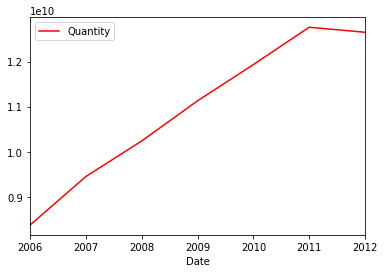

In [5]:
# Test Plot - show total sales over time
test.reset_index(inplace=True)
test.plot(kind='line',x="Date", y='Quantity',color='red')
plt.show()

In [6]:
### Get State fips code (so we can use MD or Maryland)
###
###
fips = pd.read_csv("data/fips_codes.csv", encoding="ISO-8859-1")
fips['County'] = fips['GU Name'].str.upper()
fips = fips[['State Abbreviation', 'State FIPS Code']]
fips = fips.rename(columns={'State Abbreviation': 'State'})
fips = fips.groupby(['State']).first().reset_index()
fips.set_index(['State'], inplace=True)

In [7]:
# Add state fips code to sales
sales = sales.join(fips, on=['State'])
sales = sales[~pd.isna(sales['State FIPS Code'])]
sales['State FIPS Code'] = sales['State FIPS Code'].astype(int)

In [9]:
# Pull in county population data by year
usecols=['state_fips', 'county_fips', 'state_name', 'county_name', 'pop2006', 'pop2007', 'pop2008', 'pop2009', 'pop2010', 'pop2011', 'pop2012']
pop = pd.read_csv("data/yearly/2006-2012-county_population.csv", usecols=usecols, encoding="ISO-8859-1")
pop = pop[~pd.isna(pop['county_name'])]

In [10]:
# Modify County to drop "County" and upper()
pop['County'] = pop['county_name'].str.replace(' County', '').str.replace(' City and Borough', '').str.replace(' Borough', '').str.replace(' Census Area', '').str.replace(' Municipality', '').str.replace(' Parish', '').str.replace('-', ' ').str.replace("'", '').str.upper()
pop = pop[['state_fips', 'county_fips', 'County', 'pop2006', 'pop2007', 'pop2008', 'pop2009', 'pop2010', 'pop2011', 'pop2012']]
pop = pop.rename(columns={'state_fips': 'State FIPS Code', 'county_fips': 'County FIPS Code'})

In [11]:
def fuzzyMatch(x):
    if x not in sales['County'].unique():
        matches = difflib.get_close_matches(x, sales['County'].unique())
       
        if matches:
            return matches[0]
    return x

pop['County'] = pop['County'].apply(fuzzyMatch)

# There are multiple rows for each county that have nans for some years.  Combine them and sum
pop = pop.groupby(['State FIPS Code', 'County']).aggregate({'County FIPS Code': np.max, 'pop2006': np.sum, 'pop2007': np.sum, 'pop2008': np.sum, 'pop2009': np.sum, 'pop2010': np.sum, 'pop2011': np.sum, 'pop2012': np.sum}).reset_index()


In [12]:
# Flip date columns so that they are now unique rows
pop = pop.set_index(['State FIPS Code', 'County', 'County FIPS Code'])
pop = pop.stack().reset_index().rename(columns={'level_3': 'Date', 0:'Population'})
pop['Date'] = pop['Date'].str[-4:].astype(int)

In [13]:
# Combine sales and population data
sales_indexed = sales.set_index(['Date', 'State FIPS Code', 'County'])
pop_indexed = pop.set_index(['Date', 'State FIPS Code', 'County'])
combined = sales_indexed.join(pop_indexed)
combined = combined.reset_index()
combined['Per Capita Qty'] = combined['Quantity'] / combined['Population']
combined = combined.sort_values(['Per Capita Qty'], ascending=False)

In [14]:
# Get avg per capita sales over the entire time period
avgPerCapita = combined.groupby(['County FIPS Code'])['Per Capita Qty'].mean().reset_index().sort_values(['Per Capita Qty'], ascending=False)

In [15]:
combined = combined.rename(columns={'Date': 'Year'}).drop(columns=['State FIPS Code'])

In [16]:
combined.set_index(['Year', 'County FIPS Code']).head(10)

County State     Quantity  Population  \
Year County FIPS Code                                               
2007 20103             LEAVENWORTH    KS   37013940.0     73603.0   
2006 20103             LEAVENWORTH    KS   28846740.0     72574.0   
2008 20103             LEAVENWORTH    KS   28942740.0     74355.0   
     54059                   MINGO    WV    9795100.0     26344.0   
2012 45019              CHARLESTON    SC  134658308.0    365472.0   
2011 45019              CHARLESTON    SC  124889093.0    357737.0   
2012 51720             NORTON CITY    VA    1380030.0      4049.0   
2011 51720             NORTON CITY    VA    1361170.0      4015.0   
2009 51720             NORTON CITY    VA    1211860.0      3713.0   
2010 45019              CHARLESTON    SC  113379978.0    351235.0   

                       Per Capita Qty  
Year County FIPS Code                  
2007 20103                 502.886295  
2006 20103                 397.480365  
2008 20103                 389.250757  
     54059                 371.815214  
2012 45019                 368.450409  
2011 45019                 349.108683  
2012 51720                 340.832304  
2011 51720                 339.021171  
2009 51720                 326.382979  
2010 45019                 322.803758

In [17]:
import plotly.figure_factory as ff
import numpy as np

County FIPS Code  Per Capita Qty
2837             51720      307.012867
2834             51690      241.000391
2263             45019      239.646903
919              20103      227.451905
2918             54059      206.374520

In [19]:
fips = avgPerCapita['County FIPS Code'].tolist()
values = avgPerCapita['Per Capita Qty'].tolist()

In [20]:
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(0.0, 200, len(colorscale) - 1))

In [21]:
fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    state_outline={'color': 'black', 'width': 0.5},
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='Opioid Sales Per Capita 2006-2012',
    legend_title='Opioids Per Person'
)

/Users/bovice18/anaconda3/envs/team99/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [22]:
fig.layout.template = None
fig.show()

![image info](heatmap_sales.png)

In [26]:
avgPerCapita['County FIPS Code'] = avgPerCapita['County FIPS Code'].apply(str)
avgPerCapita['County FIPS Code'] = avgPerCapita['County FIPS Code'].str.zfill(5)
avgPerCapita.to_csv('~/Downloads/opioids.csv')

In [27]:
avgPerCapita['Per Capita Qty'].mean()

38.08661348131656

In [28]:
avgPerCapita['County FIPS Code'].unique()

array(['51720', '51690', '45019', ..., '18171', '46031', '48413'],
      dtype=object)

In [29]:
avgPerCapita['County FIPS Code'].min()

'01001'